In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
from subprocess import check_call

from datetime import datetime

import numpy as np
import dask
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import cmocean

import pop_tools

import util

os.environ['CARTOPY_USER_BACKGROUNDS'] = '/glade/work/mclong/cartopy-background-img/'

In [3]:
cluster, client = util.get_ClusterClient(memory='12GB')
cluster.scale(64)
client

/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://127.0.0.1:41547,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
dsg = pop_tools.get_grid('POP_tx0.1v3')[['TLONG', 'TLAT']]
dsg

<xarray.Dataset> Size: 138MB
Dimensions:  (nlat: 2400, nlon: 3600)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLONG    (nlat, nlon) float64 69MB 250.0 250.2 250.2 ... 250.0 250.0 250.0
    TLAT     (nlat, nlon) float64 69MB -78.47 -78.47 -78.47 ... 62.34 62.34
Attributes:
    lateral_dims:       [2400, 3600]
    vertical_dims:      62
    vert_grid_file:     tx0.1v3_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/tx0.1v3/grid/horiz_grid_200709.ieeer8
    topography_fname:   inputdata/ocn/pop/tx0.1v3/grid/topography_20170718.ie...
    region_mask_fname:  inputdata/ocn/pop/tx0.1v3/grid/region_mask_20170718.i...
    type:               tripole
    title:              POP_tx0.1v3 grid

In [5]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
dird = f'/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/{case}/ocn/proc/tseries/day_1'
files = sorted(glob(f'{dird}/{case}.pop.h.nday1.FG_CO2_2.????????-????????.nc'))
assert len(files)

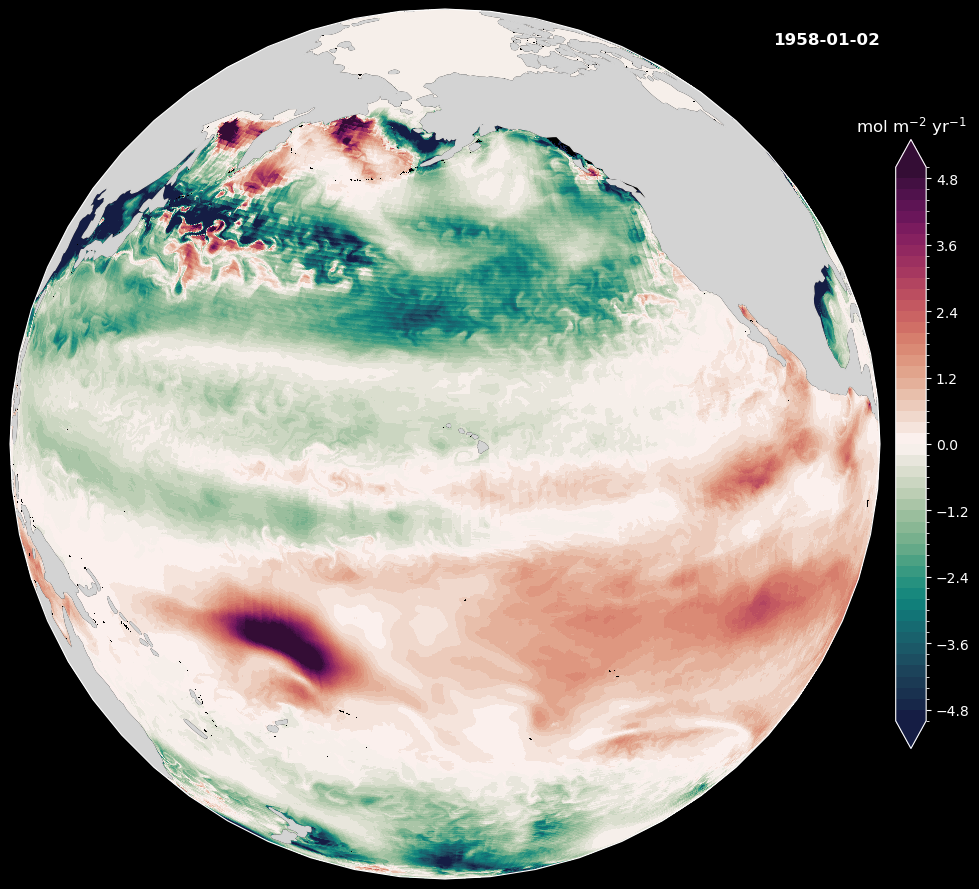

In [6]:
nmolcm2s_to_molm2yr = 1e4 * 1e-9 * 86400.0 * 365.0

with xr.open_dataset(files[0]) as ds:
    fgco2 = ds.FG_CO2_2.isel(time=0).load()
    fgco2 *= nmolcm2s_to_molm2yr * -1.0
    fgco2.attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'


def plot_frame(fgco2, time_level, diro=None):
    plt.style.use("dark_background")
    prj = ccrs.NearsidePerspective(
        central_longitude=200,
        central_latitude=20,
        false_easting=0, 
        false_northing=0, 
        globe=None)

    cmap = cmocean.cm.curl
    levels = np.arange(-5.0, 5.2, 0.2)

    fig, ax = plt.subplots(
        figsize=(12, 12), 
        facecolor='k',
        subplot_kw=dict(projection=prj),
    )
    #ax.background_img('natural-earth-1-no-ocean', resolution='large4096px')

    ax.coastlines()

    pc = ax.pcolormesh(
        dsg.TLONG, dsg.TLAT, fgco2, 
        cmap=cmap,
        norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='lightgrey'
        )
    )   

    cb = fig.colorbar(pc, shrink=0.7, extend='both', pad=0.01)
    cb.ax.set_title('mol m$^{-2}$ yr$^{-1}$', y=1.05, color='w')

    ax.set_title(
        fgco2.time.values.item().strftime('%Y-%m-%d'), 
        loc='right', y=0.95, fontweight='bold', color='w')

    fig_size = (16, 9)
    fig.set_size_inches(fig_size)
    fig.tight_layout()

    if diro is not None:
        fig.savefig(f'{diro}/{time_level:04d}.png', dpi=300)
        plt.close()           

plot_frame(fgco2, 1)      

In [7]:
import netCDF4

In [ ]:
%%time
diro = 'fgco2-frames'
check_call(['rm', '-fr', diro])
os.makedirs(diro, exist_ok=True)

n = 0
for f in files[-5:]: 
    
    with xr.open_dataset(f, chunks={'time': 1}) as ds:
        fgco2 = ds.FG_CO2_2
        fgco2 *= nmolcm2s_to_molm2yr * -1.0
        fgco2 = fgco2.persist()
        
    print(f'starting time loop: {os.path.basename(f)}')
    
    del_objs = []
    for i in range(ds.sizes['time']):
        del_objs.append(dask.delayed(plot_frame)(fgco2.isel(time=i), n, diro=diro))
        n += 1

    computed_objs = dask.compute(*del_objs)

starting time loop: g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20170102-20180101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 132.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
del client
del cluster

In [ ]:
%%bash

MOVOUT=fgco2.mp4
FPS=12
ffmpeg_cmd="ffmpeg -y -start_number 1 -r ${FPS} -i fgco2-frames/%04d.png"
ffmpeg_cmd="${ffmpeg_cmd} -c:v libx264 -pix_fmt yuv420p "
ffmpeg_cmd=${ffmpeg_cmd}' -vf "scale=1440:trunc(ow/a/2)*2" -movflags faststart'

cmd="${ffmpeg_cmd} ${MOVOUT} ;"
echo ${cmd}
eval ${cmd}